In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

from sklearn.model_selection import train_test_split

import prepro
import classification as cn

In [2]:
rand_seed = 667

In [3]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

In [4]:
df = pd.read_excel("data/train_file.xlsx")

In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'y'],
      dtype='object')

## Feature Summary
### We have 14 features and a binary target variable

In [6]:
# target
target_var = ["y"]

# categorical variables
cat_cols = ["education",
            "job",
            "marital",
            "default",
            "housing",
            "loan",
            "contact",
            "month",
            "day_of_week",
            "campaign",
            "previous",
            "poutcome"
]

# contiuous variables
cont_cols = ["age",
             "duration"
    
]

In [7]:
df.head()

age           job   marital          education  default housing loan   
0   49   blue-collar   married           basic.9y  unknown      no   no  \
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  previous     poutcome    y  
0   cellular   nov         wed       227         4         0  nonexistent   no  
1  telephone   nov         wed       202         2         1      failure   no  
2   cellular   jul         mon      1148         1         0  nonexistent  yes  
3  telephone   may         mon       120         2         0  nonexistent   no  
4   cellular   jun         tue       368         2         0  nonexistent   no

### We have highly unbalanced data

<Axes: >

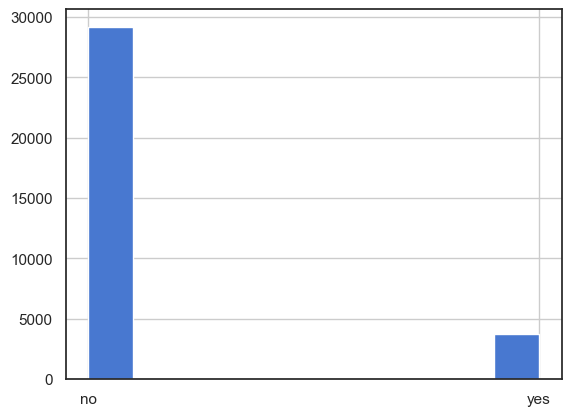

In [8]:
df["y"].hist()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

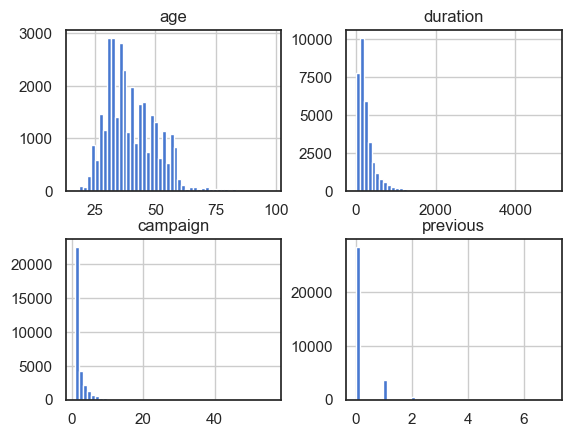

In [9]:
# keep age and duration continuous
# treat campaign and previous as categorical
df.hist(bins=50)

### Longer calls are more likely to lead to subscription

<Figure size 640x480 with 0 Axes>

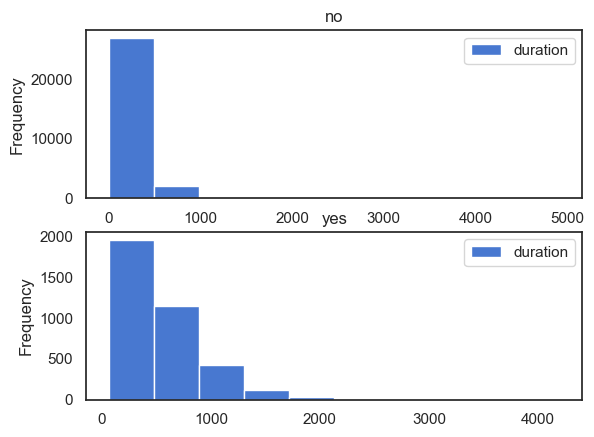

In [10]:
fig = plt.figure()
df.plot.hist(column="duration", by="y")
fig.tight_layout()

### Missing values:
* job -> unknown
* marital -> unknown
* education -> unknown
* default -> unknown
* housing -> unknown
* loan -> unknown
* poutcome -> nonexistent?

In [11]:
for col in df.columns:
    print(f"--------------------------- {col} ---------------------------")
    print(df[col].unique())
    print("")

--------------------------- age ---------------------------
[49 37 78 36 59 29 26 30 50 33 44 32 43 56 40 47 34 46 39 41 55 38 63 23
 48 53 35 51 71 58 21 45 25 77 28 52 80 57 22 60 27 24 31 42 54 81 64 79
 20 76 82 19 68 65 73 66 85 74 61 86 69 18 83 88 70 87 84 75 62 72 67 89
 17 91 98]

--------------------------- job ---------------------------
['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'unknown'
 'housemaid']

--------------------------- marital ---------------------------
['married' 'divorced' 'single' 'unknown']

--------------------------- education ---------------------------
['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'unknown' 'basic.6y' 'illiterate']

--------------------------- default ---------------------------
['unknown' 'no' 'yes']

--------------------------- housing ---------------------------
['no' 'yes' 'unknown']

--------------------------- loan 

### Missing values -> counts
#### Relatively few counts in
* job
* marital
* education
* housing
* loan

#### Relatively many counts in
* default
* poutcome


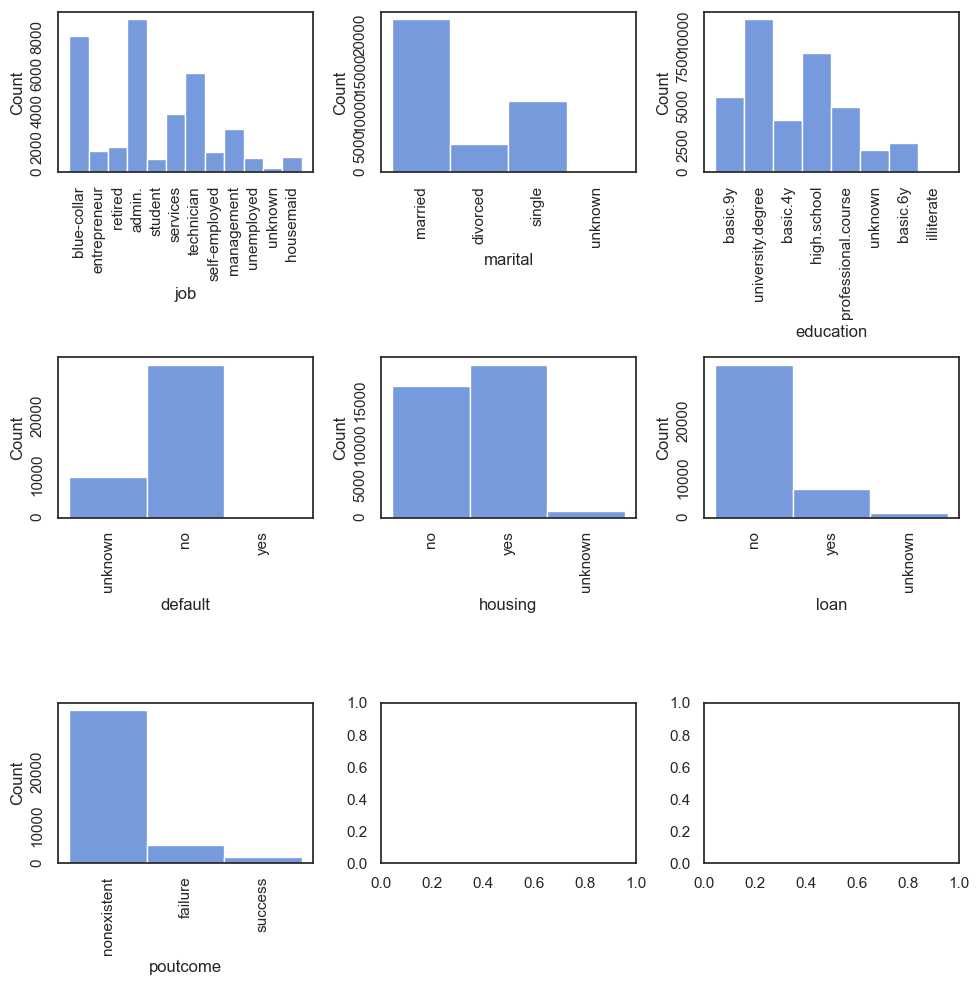

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = np.reshape(axes, (1,-1))

missing_val_cols = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]

for ind, col in enumerate(missing_val_cols):    
    sns.histplot(df[col], ax=axes[0][ind])
    axes[0][ind].tick_params(labelrotation=90)    
    
fig.tight_layout()

### Are missing values related to target variable? -> Test for independence using chi2 test
#### Probably independent:
* job -> impute
* marital -> impute
* housing -> drop (p ~= 1)
* loan -> drop (p ~= 1)

#### Probably dependent:
* education -> impute
* default -> keep (no >> yes)
* poutcome -> keep (nonexistent >> failure; is nonexistent even a missing class?)

In [13]:
for col in missing_val_cols:
    if col == "poutcome":
        miss_label = "nonexistent"
    else:
        miss_label = "unknown"
            
    res, ct = prepro.test_independence(df, col_y="y", col_x=col, missing_vals=miss_label)
    
    if res.pvalue < 0.05:
        is_significant = "*"
    else:
        is_significant = ""
    
    print(f"--------- {col} ---------")    
    print(f"p ={res.pvalue: 0.5f}, {is_significant}")

--------- job ---------
p = 0.58918, 
--------- marital ---------
p = 0.21196, 
--------- education ---------
p = 0.00002, *
--------- default ---------
p = 0.00000, *
--------- housing ---------
p = 1.00000, 
--------- loan ---------
p = 1.00000, 
--------- poutcome ---------
p = 0.00000, *


### Drop missing values of non-important columns

In [14]:
# drop missing values for housing and loan
df_dropped = prepro.drop_missing(df, cols=["housing", "loan"], missing_vals="unknown")

### Split data into training and test sets 70 / 30

In [15]:
df_train, df_test = train_test_split(df_dropped, train_size=0.7, random_state=rand_seed)

print(f"Training set with {len(df_train)} samples")
print(f"Test set with {len(df_test)} samples")

Training set with 22480 samples
Test set with 9635 samples


Data set with 22480 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Imputing missing values ...
Data set with 9635 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Found existing encoder for y
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Imputing missing values ...


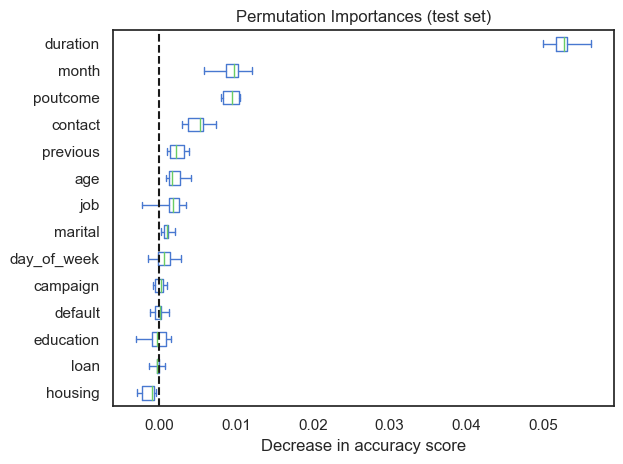

In [16]:
# plot feature importance using permutations
cn.plot_feature_importance_rf(df_train, df_test, cont_cols=cont_cols, cat_cols=cat_cols, rand_seed=rand_seed)

## EDA Summary:

### Feature importance
Based on an approach involving random forest classification and feature permutation we find the parameter call duration by far as the most important feature in the data set at hand.
This may be explained by the fact that customers that show more interest in the product may aslo be willing to spend more time to hear about. Alternatively, the more time a given customer may have heard about a product the more convinced he/she might be in the end.

Besides duration, the month in which the call took place played a role in prediction and so also did the contact type a given customer was approached.

On top of that also "poutcome" did play a role in prediciton performance.
Unfortunately, the variable was not well documented in the problem statement and thus cannot be welll interpreted here.

Data set with 22480 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Imputing missing values ...
Dummy coding categorical variables ...
Done
Counter({0.0: 19977, 1.0: 19977})
Data set with 9635 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Found existing encoder for y
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Imputing missing values ...
Dummy coding categorical variables ...
Done
Found a set di

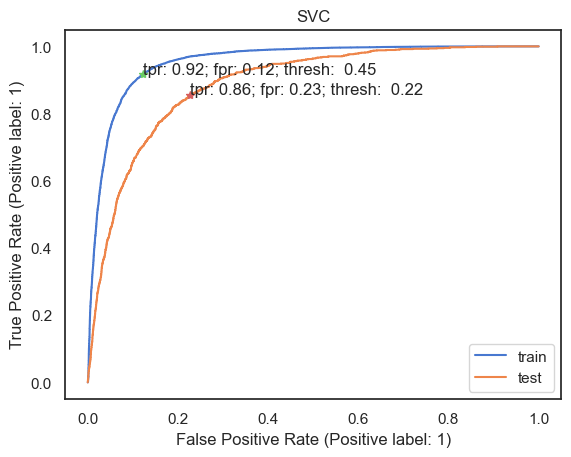

In [17]:
# try linear svm
model, enc_dict, scaler_cont, scaler_ord, mc_kernel, col_dict = cn.train_classifier(
    "svm", df_train, df_test, cont_cols, cat_cols, grid_search=False, rand_seed=667
)

Data set with 22480 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Scaling ordinal variables ...
Imputing missing values ...
Counter({0.0: 19977, 1.0: 19977})
Data set with 9635 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Found existing encoder for y
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Scaling ordinal variables ...
Using provided scaler for features: ['education' 'job' 'marital' 'defa

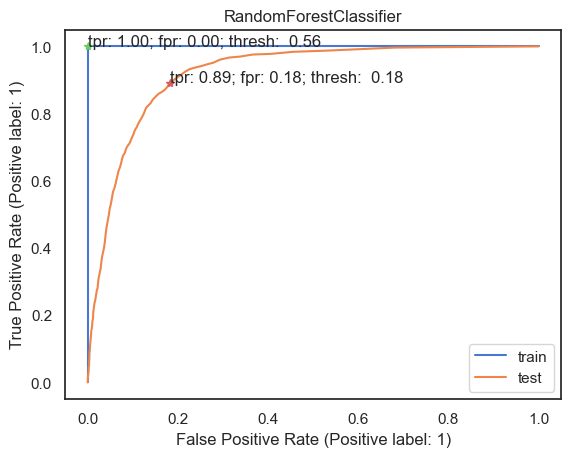

In [18]:
# try linear svm
model, enc_dict, scaler_cont, scaler_ord, mc_kernel, col_dict = cn.train_classifier(
    "rf", df_train, df_test, cont_cols, cat_cols, grid_search=False, rand_seed=667
)

Data set with 22480 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Scaling ordinal variables ...
Imputing missing values ...
Counter({0.0: 19977, 1.0: 19977})
Data set with 9635 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Found existing encoder for y
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Scaling ordinal variables ...
Using provided scaler for features: ['education' 'job' 'marital' 'defa

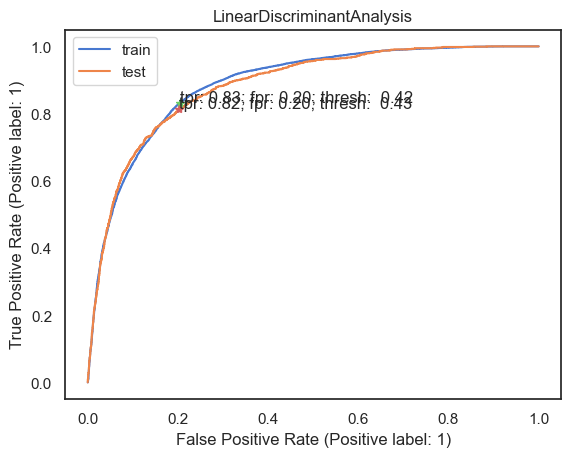

In [19]:
# try linear discriminant analysis classifier
model, enc_dict, scaler_cont, scaler_ord, mc_kernel, col_dict = cn.train_classifier(
    "lda", df_train, df_test, cont_cols, cat_cols, grid_search=False, rand_seed=667
)

Data set with 22480 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Imputing missing values ...
Counter({0.0: 19977, 1.0: 19977})
Data set with 9635 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Found existing encoder for y
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Imputing missing values ...
Found a set difference in columns between test and trainin set - filling in dummy columns ...
[]
plott

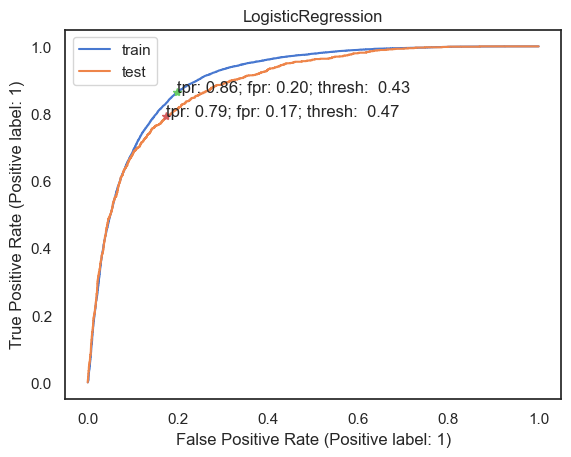

In [20]:
# try logistic regression
model, enc_dict, scaler_cont, scaler_ord, mc_kernel, col_dict = cn.train_classifier(
    "logreg", df_train, df_test, cont_cols, cat_cols, grid_search=False, rand_seed=667
)

In [21]:
# finally use all data for training to maximize prediction outcome of third party test set
# -> use random forest
df_all = pd.concat([df_train, df_test], axis=0)

model, enc_dict, scaler_cont, scaler_ord, mc_kernel, col_dict = cn.train_classifier(
    "rf", df_all, df_test=None, cont_cols=cont_cols, cat_cols=cat_cols, grid_search=False, persist=True, rand_seed=667)

Data set with 32115 samples
Transforming categorical variables ...
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Scaling continuous variables ...
Scaling ordinal variables ...
Imputing missing values ...
Counter({0.0: 28498, 1.0: 28498})


In [23]:
# load model and predict
import pickle

file = open(b"./models/rf_final.pickle",'rb')
model_dict = pickle.load(file)

df_valid = pd.read_excel("data/test_file.xlsx")

# predict third party test set
y_pred = cn.predict_from_dict(model_dict, df_valid)

Predicting with RandomForestClassifier ...
Data set with 40 samples
Transforming categorical variables ...
Found existing encoder for education
Found existing encoder for job
Found existing encoder for marital
Found existing encoder for default
Found existing encoder for housing
Found existing encoder for loan
Found existing encoder for contact
Found existing encoder for month
Found existing encoder for day_of_week
Skipping campaign as it is already numeric!
Skipping previous as it is already numeric!
Found existing encoder for poutcome
Scaling continuous variables ...
Using provided scaler for features: ['age' 'duration']!
Scaling ordinal variables ...
Using provided scaler for features: ['education' 'job' 'marital' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'campaign' 'previous' 'poutcome']!
Imputing missing values ...


In [ ]:
# save results
subs = ["yes" if y==1 else "no" for y in y_pred]
df_valid["y_pred"] = subs
df_valid["y_pred_bin"] = y_pred
df_valid.to_csv("./data/predictions.csv")

## Insight Summary:

For an upcoming marketing campaign we may be interested in predicting new customers that likely subscribe to our product. In this scenario, we ideally would like to invest our resources only in those customers that actually will subscribe to the product while ignoring all (or at least as many as possible) other customers.

### Metric

To address the imbalance issue, oversampling is used.

Still, due to the small amount of subscription in the available data, accuracy is not the metric of choice for classifier selection.

On top of that, correctly labeling a customer, willing to subscribe to our product may be preferrable than correctly labeling a customer not willing to subscrib.

The above described tradeoff is known as the compromise between true positives (customers we correctly classified as subscribers) and false positives (customers that we thought might subscribe but then did not).
We thus aim to maximize the former while minimizing the latter.

For this purpose we suggest the reciever operator characteristic (ROC)

### Results

Based on this metric, the current analysis suggests to use a random forest classifier or a linear support vector machine for the problem at hand.

### Next Steps

#### Imputer
Imputation performance should be systematically evaluated.
For now we went with defaults and best practise.
Nevertheless, multivariate imputation is likely superior to naive mean / most frequent insertion.

#### Hyperparameter Tuning
Due to the limited amount of time, classifiers were so far, more or less compared with their default parameters
and only minimal parameter tuning.

A next (time intensive) step could be to run an exhaustive grid search for each classifier with its corresponding key parameters

This search may also involve systematic variation of preprocessing parameters, which so far have been selected based on prior experience and best practise, only.

#### Deep Learning
A potential next step may be to test the performance with feed forward neural network.
A quick exploration analysis using the scikit learn interface did not lead to substantially higher performance, as compared to the shown classifiers.
However, the scikit learn API is a bit limited for neural nets and an additional approach using PyTorch might be interesting.

#### Causlity & Causal Inference
It may be interesting to find out what features may have causal impacts on the subscription rate.
Causality here could be approached using causal inference and Bayesian methods.
For starters, I would like trying to fit a Bayes-Net on the data at hand and see whether the structure makes intutively sense.
As an additional step one could consult expert knowledge to validate such a network structure.
Once a valid structure has be found conditional probabilities could be learnt from the data.
In an ideal scenario one could then try to find out how single factors (i.e. features) interacto with subscription, e.g. using Bayesian interventions.